### Requirements & Configurations

In [1]:
import sys  
sys.path.insert(0, '../')

In [2]:
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from catboost import CatBoostClassifier, Pool

from torch import nn
from IPython.display import clear_output
from tqdm import tqdm_notebook, tqdm
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader
from itertools import repeat
from data import *

import torch
import torch.nn.utils.prune as prune
import torch.nn.functional as F

import core.data.rich_utils as rich_utils

import wandb
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os

%matplotlib inline

In [3]:
PARTICLE_TYPE = 'pion'

BATCH_SIZE = 4096
BATCH_SIZE_VAL = 1024
LATENT_DIMENSIONS = 128
NOISE_SIZE = 128
CRAMER_DIM = 512
NUM_LAYERS = 10

CRITIC_ITERATIONS_CONST = 10
TOTAL_ITERATIONS = int(6e4)
VALIDATION_INTERVAL = 10000

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

### Load dataset

In [4]:
from core.data.datasets import ParticleDataset
               

data_train, data_val, scaler = rich_utils.get_merged_typed_dataset(PARTICLE_TYPE, dtype=np.float32)
    
train_loader = torch.utils.data.DataLoader(ParticleDataset(data_train.values),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    pin_memory=True)

val_loader = torch.utils.data.DataLoader(ParticleDataset(data_val.values),
                                                  batch_size=BATCH_SIZE_VAL,
                                                  shuffle=False,
                                                  pin_memory=True)

scaler train sample size: 1500000
scaler n_quantiles: 100000, time = 2.130542278289795


In [5]:
data_train.head(3)

,RichDLLe,RichDLLk,RichDLLmu,RichDLLp,RichDLLbt,Brunel_P,Brunel_ETA,nTracks_Brunel,probe_sWeight
0,0.482666,0.053458,0.053947,-0.548041,0.269786,0.720969,0.676907,0.097714,0.883707
1,1.486169,-0.762816,1.142220,-0.881954,-0.295823,0.421586,-1.315679,0.559815,0.912539
2,-0.659258,0.147714,-0.582184,0.318019,0.308314,-0.715213,0.341952,1.057633,1.086270


### Load a model 

In [6]:
from torch.quantization import QuantStub, DeQuantStub

class Generator(nn.Module):
    def __init__(self, hidden_size=128, depth=5):
        super(Generator, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(LATENT_DIMENSIONS + data_train.shape[1] - 1 - rich_utils.y_count, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.LeakyReLU(0.1),
            *[nn.Sequential(
                nn.utils.spectral_norm(nn.Linear(hidden_size, hidden_size)),
                nn.BatchNorm1d(hidden_size),
                nn.LeakyReLU(0.1)) for _ in range(depth)
             ],
            nn.Linear(hidden_size, rich_utils.y_count)
        )
        
    def forward(self, x, noise=None):
        x = torch.cat([x, get_noise(x.shape[0])], dim=1)
        x = self.layers(x)
        return x
    
    def fuse_model(self):
        for i in self.layers:
            pass
    
class Critic(nn.Module):
    def __init__(self, hidden_size=128, depth=5):
        super(Critic, self).__init__()
        self.layers = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(data_train.shape[1] - 1, hidden_size)),
            nn.LayerNorm(hidden_size),
            nn.LeakyReLU(0.1),
            *[nn.Sequential(
                nn.utils.spectral_norm(nn.Linear(hidden_size, hidden_size)),
                nn.LayerNorm(hidden_size),
                nn.LeakyReLU(0.1))
              for _ in range(depth)],
            nn.utils.spectral_norm(nn.Linear(hidden_size, 1)),
        )

    def forward(self, x):
        return self.layers(x)

    
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0)

        
def get_noise(batch_size, mean=0, std=1):
    return torch.zeros(batch_size, LATENT_DIMENSIONS).normal_(mean, std).to(device)


def generate(generator, device='cuda', loader=val_loader, iterations=None):
    generator.eval()
    
    dlls = None
    generated = None
    weights = None
    features = None

    with torch.no_grad():
        current_iterations = 0
        for x, weight, real in loader:
            weight = weight.detach().cpu().numpy()
            dll = real.detach().cpu().numpy()
            x = x.to(device)
            gen = generator(x).detach().cpu().numpy()
            x = x.detach().cpu().numpy()

            if dlls is None:
                dlls = dll
            else:
                dlls = np.concatenate((dlls, dll))

            if weights is None:
                weights = weight
            else:
                weights = np.concatenate((weights, weight))

            if generated is None:
                generated = gen
            else:
                generated = np.concatenate((generated, gen))
            
            if features is None:
                features = x
            else:
                features = np.concatenate((features, x))
            
            current_iterations += 1
            if iterations is not None and current_iterations > iterations:
                break
    return dlls, generated, weights, features


def infinity_generate(generator, device='cuda', iterations=1000):
    generator.eval()
    
    dlls = None
    generated = None
    weights = None
    features = None

    with torch.no_grad():
        for i in range(iterations):
            x, weight, real = infinite_train_loader.get_next()
            weight = weight.detach().cpu().numpy()
            dll = real.detach().cpu().numpy()
            x = x.to(device)
            gen = generator(x).detach().cpu().numpy()
            x = x.detach().cpu().numpy()

            if dlls is None:
                dlls = dll
            else:
                dlls = np.concatenate((dlls, dll))

            if weights is None:
                weights = weight
            else:
                weights = np.concatenate((weights, weight))

            if generated is None:
                generated = gen
            else:
                generated = np.concatenate((generated, gen))
            
            if features is None:
                features = x
            else:
                features = np.concatenate((features, x))
            
    return dlls, generated, weights, features

In [7]:
netG = Generator(depth=2).to(device)
netC = Critic(depth=2).to(device)

netC.load_state_dict(torch.load('../weights/C_teacher.pth', map_location={'cuda:3':device}))
netG.load_state_dict(torch.load('../weights/G_teacher.pth', map_location={'cuda:3':device}))

<All keys matched successfully>

In [ ]:
## calculate time in cpu
import time

x = next(iter(val_loader))[0]

start_time = time.time()
with torch.no_grad():
    for _ in range(10000):
        netG(x)
    
print("--- %s seconds ---" % (time.time() - start_time))

In [8]:
def fuse_model(layers):
    new_layers = nn.Sequential()
    for idx, i in enumerate(layers):
        if type(i) == nn.Linear:
            linear_layer = i
            i = nn.Sequential(QuantStub(), linear_layer, DeQuantStub())
        elif type(i) == nn.Sequential:
            i = fuse_model(i)
        new_layers.add_module(str(idx), i)
    return new_layers

netG.layers = fuse_model(netG.layers)

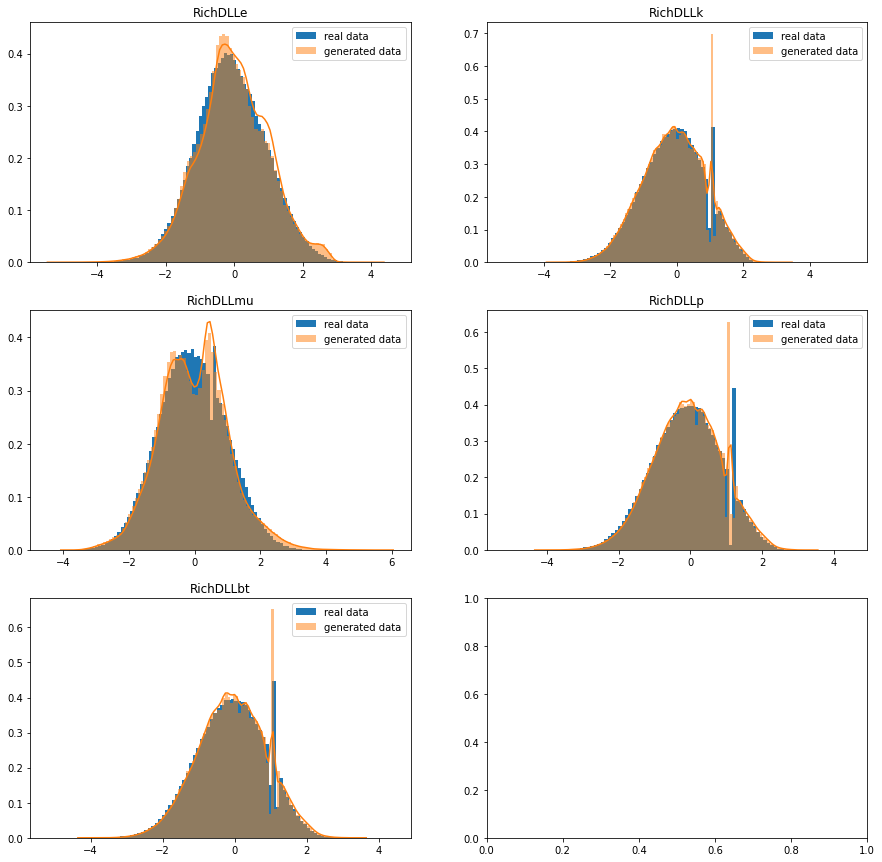

In [10]:
from core.metrics import hists

dlls, generated, weights, features = generate(netG)
hists.plot_1d_hist(dlls, generated, hist_kws={'weights': weights});

### Static quantization

In [9]:
from core.metrics import classification, kolmogorov_smirnov
from omegaconf.dictconfig import DictConfig

# stamp config
config = DictConfig({"metric": {"classification": {"iterations": 1000, "depth": None, "split_size": 0.99, "verbose_each_iter": 0}}, 
                     "utils": {"device": "cuda:0"}})

In [10]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

In [11]:
class InfiniteDataloader:
    def __init__(self, loader):
        self.loader = loader
        self.iter = iter(self.loader)

    def get_next(self):
        try:
            return next(self.iter)
        except StopIteration:
            self.iter = iter(self.loader)
            return self.get_next()

infinite_train_loader = InfiniteDataloader(train_loader)

In [35]:
import torch.quantization
import functools
import copy 

def static_quantization(generator, observer, dtype=torch.qint8, num_calibration_batches=10000):
    print("Size of model before quantization")
    print_size_of_model(generator)

    # Specify quantization configuration
    # Start with simple min/max range estimation and per-tensor quantization of weights
    generator.qconfig = torch.quantization.QConfig(
        activation=functools.partial(observer, reduce_range=True),
        weight=functools.partial(observer, dtype=dtype, qscheme=torch.per_tensor_symmetric)
    )
    
    torch.quantization.prepare(generator, inplace=True)

    # Calibrate with the training set
    infinity_generate(generator, device='cpu', iterations=num_calibration_batches)
    # Convert to quantized model
    torch.quantization.convert(generator, inplace=True)

    print("Size of model after quantization")
    print_size_of_model(generator)
    
    return generator

#### MinMaxObserver

Size of model before quantization
Size (MB): 0.426949
Size of model after quantization
Size (MB): 0.127249


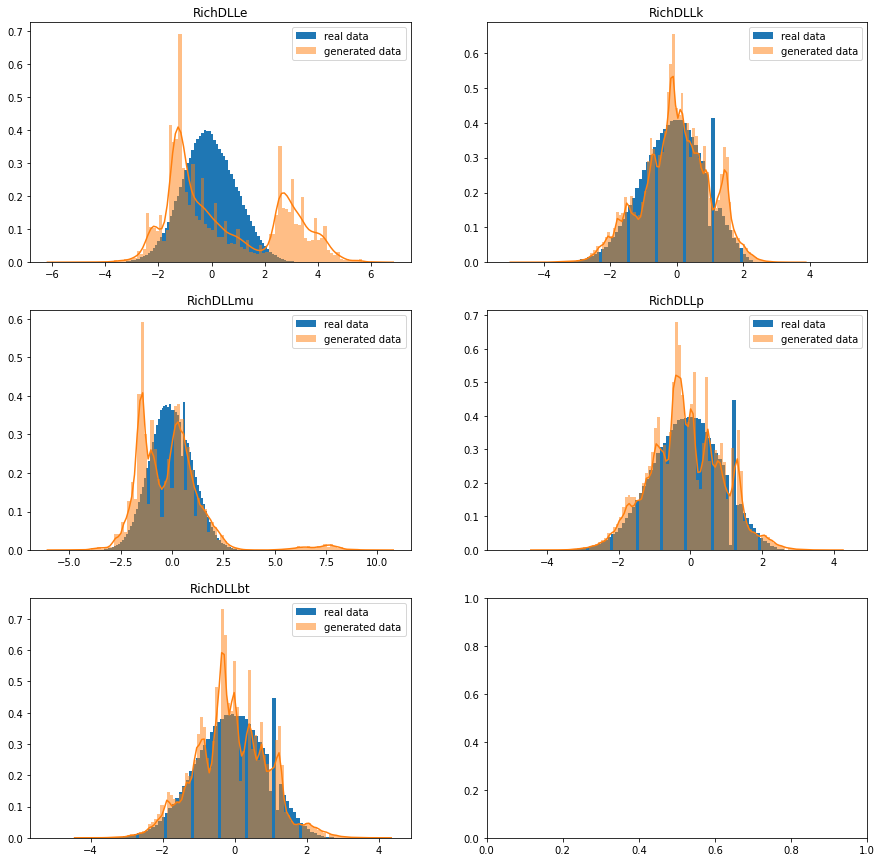

In [36]:
device = 'cpu'
netG.cpu()
netG.eval()
generator = copy.deepcopy(netG)

generator = static_quantization(generator, observer=torch.quantization.observer.MinMaxObserver, 
                                num_calibration_batches=5000)
dlls, generated, weights, features = generate(generator, device='cpu')
hists.plot_1d_hist(dlls, generated, hist_kws={'weights': weights});

#### HistogramObserver

Size of model before quantization
Size (MB): 0.426949
Size of model after quantization
Size (MB): 0.127249


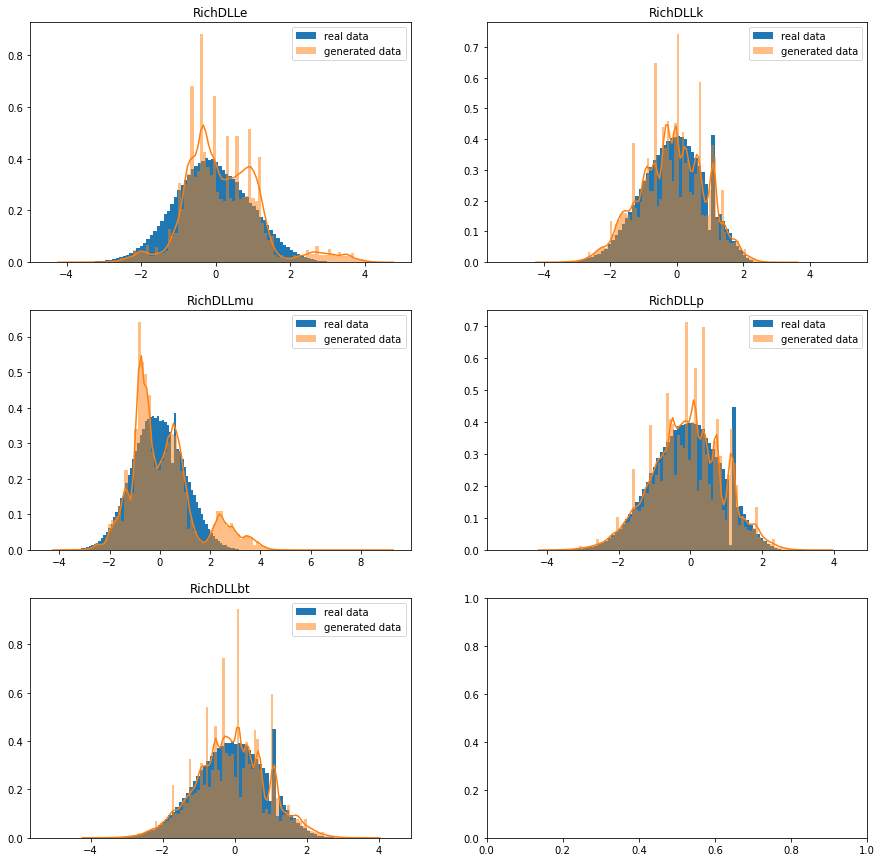

In [37]:
device = 'cpu'
netG.cpu()
netG.eval()
generator = copy.deepcopy(netG)

generator = static_quantization(generator, observer=torch.quantization.observer.HistogramObserver, 
                                num_calibration_batches=5000)
dlls, generated, weights, features = generate(generator, device='cpu')
hists.plot_1d_hist(dlls, generated, hist_kws={'weights': weights});

#### PerChannelMinMaxObserver

In [41]:
num_calibration_batches = 5000

generator = copy.deepcopy(netG)
device = 'cpu'
generator.cpu()
generator.eval()

print("Size of model before quantization")
print_size_of_model(generator)

generator.qconfig = torch.quantization.get_default_qconfig('fbgemm')
torch.quantization.prepare(generator, inplace=True)

infinity_generate(generator, device='cpu', iterations=num_calibration_batches)
torch.quantization.convert(generator, inplace=True)

print("Size of model after quantization")
print_size_of_model(generator)

Size of model before quantization
Size (MB): 0.426949
Size of model after quantization
Size (MB): 0.141168


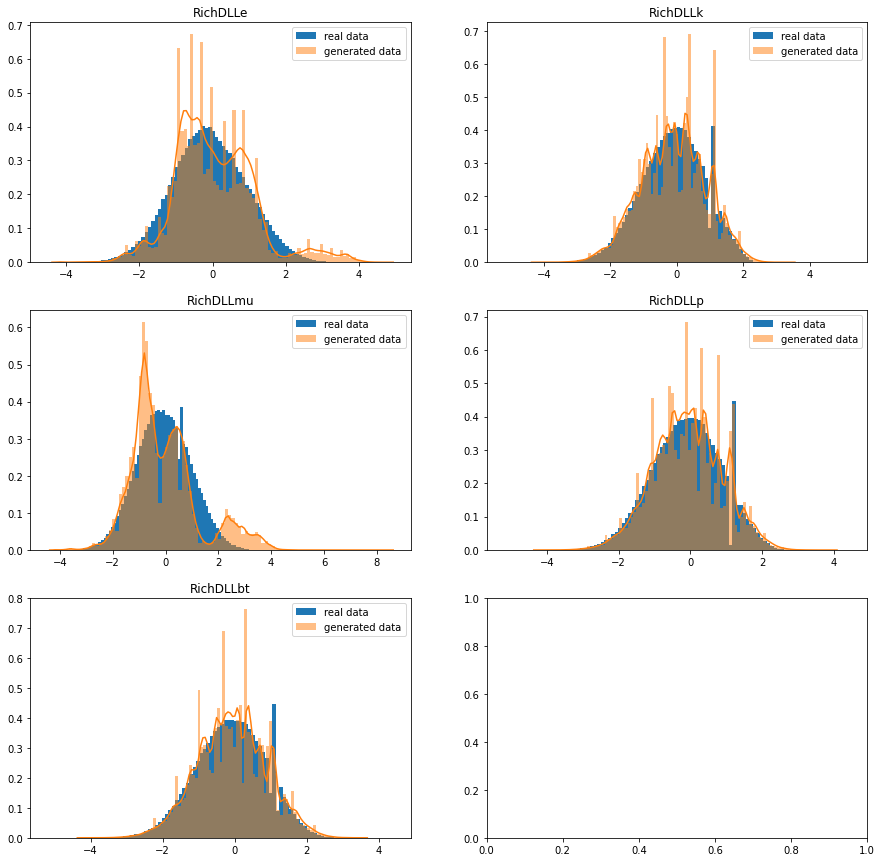

In [42]:
device = 'cpu'
generator.cpu()
generator.eval()
dlls, generated, weights, features = generate(generator, device='cpu', iterations=1000000)
hists.plot_1d_hist(dlls, generated, hist_kws={'weights': weights});

In [43]:
## calculate time in cpu
import time

x = next(iter(val_loader))[0]

start_time = time.time()
with torch.no_grad():
    for _ in range(10000):
        generator(x)
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 37.16086387634277 seconds ---


### Dinamic quantinization

In [29]:
num_calibration_batches = 10000
device='cpu'

netG = Generator(depth=2).to(device)
netC = Critic(depth=2).to(device)

netC.load_state_dict(torch.load('../weights/C_student_distill.pth', map_location={'cuda:3':device}))
netG.load_state_dict(torch.load('../weights/G_student_distill.pth', map_location={'cuda:3':device}))

generator = copy.deepcopy(netG)
generator.cpu()
generator.eval()

generator.qconfig = torch.quantization.get_default_qconfig('fbgemm')
torch.quantization.prepare(generator, inplace=True)

generate(generator, device='cpu', iterations=num_calibration_batches, loader=train_loader)

generator = torch.quantization.quantize_dynamic(
    generator, {nn.Linear, nn.LeakyReLU}, dtype=torch.qint8
)

print_size_of_model(generator)

Size (MB): 0.070002


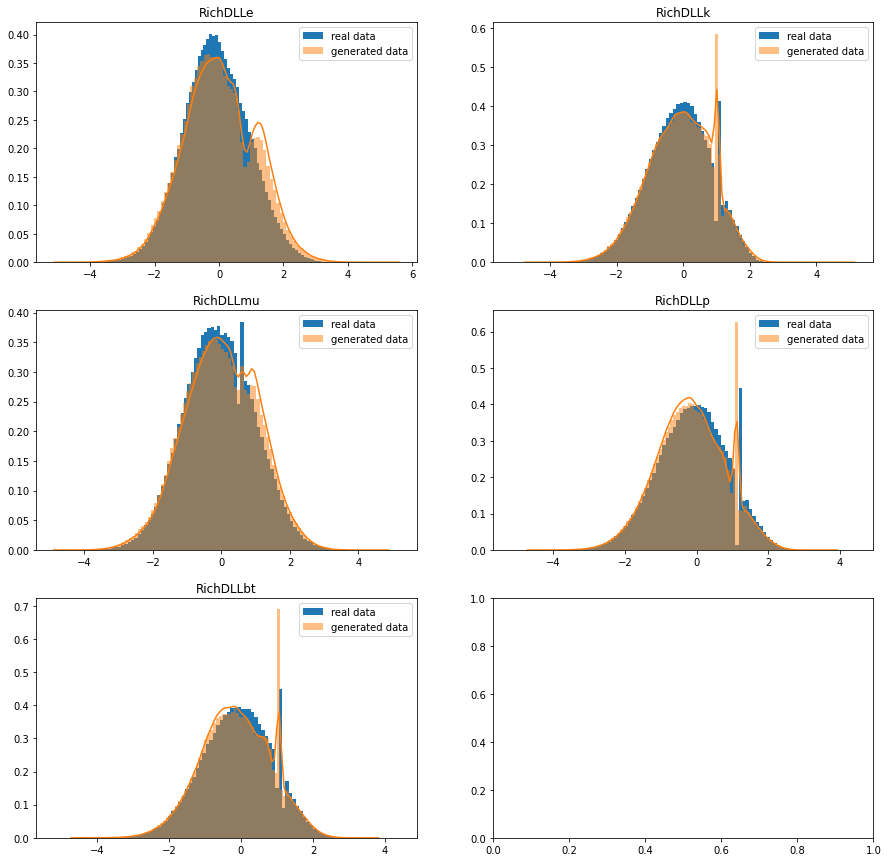

In [30]:
device = 'cpu'
generator.cpu()
generator.eval()
dlls, generated, weights, features = generate(generator, device='cpu')
hists.plot_1d_hist(dlls, generated, hist_kws={'weights': weights});

In [31]:
torch.save(generator.state_dict(),f'G_distill_quant.pth')
torch.save(netC.state_dict(),f'C_distill_quant.pth')

In [32]:
import time

## calculate time in cpu

x = next(iter(val_loader))[0]

start_time = time.time()
with torch.no_grad():
    for _ in range(10000):
        generator(x)
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 36.905253648757935 seconds ---
